In [1]:
## Table 1 Results: montonocity sublinearity and explain variance (PCA) or R^2 (PLS)
save_path = 'ICLR_results'
import sys
if len(sys.argv) > 1:
    model_key = sys.argv[1]
else:
    raise ValueError("Enter  model Name")

from utils.data_utils import search_models
model_name = search_models('llama')
# model_name = "deepseek-ai/deepseek-llm-7b-base"
Example: print(model_name)


from dataclasses import dataclass
@dataclass
class ArgumentParser:
    transform: str = "PCA"              # dimensionality reduction method: "PCA" or "PLS"
    Tdim: int = 1                       # number of target dimensions after transform
    k: int = 30                         # group/examples
    num_examples: int = 3               # number of demonstrations
    context: str = 'random'             # type of context (e.g., 'random' vs. fixed)
    data: str = 'numerics'              # dataset type to use numerics or symbols
    groups = [1,2,3,4]   # groups to test; here each group is 10**i
    upper_bound: int = 10**groups[-1]   # upper bound for generated numbers (max context size)
    save: bool = True                   # whether to save results
    plot: bool = True                   # whether to plot results
    model_name: str = model_name  # model identifier (e.g., huggingface repo name)
    device: str = "0"                   # GPU device number (string)
    runs: int = 3                       # number of runs
args = ArgumentParser()

meta-llama/Llama-2-7b-hf


In [2]:
from main_lab import analyzer
res = analyzer(args)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:49<00:00, 24.89s/it]


In [3]:
model_num_layer = res.model.config.num_hidden_layers
model = res.model
tokenizer = res.tokenizer
device = res.device

In [4]:
import torch
import pandas as pd

# Initialize results as a dict-of-dicts for each layer, to avoid KeyError
results = {i: {'hidden_states': {}, 'answers': {},'pred_answers': {}} for i in range(model_num_layer)}
log = []
data = pd.read_csv('population.csv')
rows = len(data)
cols = len(list(data.columns))
print('number of examples:', rows, 'number of columns: ', cols)
data = data[['value', 'prompts']]
data = data.sort_values(by='value')
prompts_list, answers_list = data.prompts.tolist(), data.value.tolist()
prompts = {'prmts': {}, 'ans': {}}
num_groups = 10
gap = (max(answers_list) - min(answers_list)) / num_groups
for j in range(num_groups):
    prompts['prmts'][j] = [prompts_list[i] for i in range(len(prompts_list)) if 1000 + gap * (j) < answers_list[i] < 1000 + gap * (j + 1)]
    prompts['ans'][j] = [answers_list[i] for i in range(len(prompts_list)) if 1000 + gap * (j) < answers_list[i] < 1000 + gap * (j + 1)]


number of examples: 1000 number of columns:  5


In [5]:
import torch
import pandas as pd

# Initialize results as a dict-of-dicts for each layer, to avoid KeyError
results = {i: {'hidden_states': {}, 'answers': {},'pred_answers': {}} for i in range(model_num_layer)}
log = []
data = pd.read_csv('population.csv')
rows = len(data)
cols = len(list(data.columns))
print('number of examples:', rows, 'number of columns: ', cols)
data = data[['value', 'prompts']]
data = data.sort_values(by='value')
data = data.reset_index(drop=True)
prompts_list, answers_list = data.prompts.tolist(), data.value.tolist()
prompts = {'prmts': {}, 'ans': {}}
num_groups = 10
gap = (max(answers_list) - min(answers_list)) / num_groups
for j in range(num_groups):
    prompts['prmts'][j] = [prompts_list[i] for i in range(len(prompts_list)) if 100 * j < i < 100 * (j + 1)]
    prompts['ans'][j] = [answers_list[i] for i in range(len(prompts_list)) if 100 * j < i < 100 * (j + 1)]


number of examples: 1000 number of columns:  5


In [6]:

correct = 0
loss = 0
timer = 1
total_complexity = len(prompts['prmts'])
for (group, prompt_list), (group_ans, ans_list) in zip(prompts['prmts'].items(), prompts['ans'].items()):
    print(timer/total_complexity,end='|')
    timer+=1
    group_hidden_states = {i: [] for i in range(model_num_layer)}
    group_answers = []
    predicted_ans = []
    for prompt, crr_answer in zip(prompt_list, ans_list):
        counter = 0
        prompt_for_model = prompt  # Avoid changing original prompt object
        num_digits = 0
        ans = ''
        while True:
            inputs = tokenizer(prompt_for_model, return_tensors="pt").to(device)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_vec = outputs[0][0][-1]  # shape: |V|
            predicted_id = torch.argmax(hidden_vec).item()
            predicted_token = tokenizer.decode([predicted_id])
            if predicted_token.isdigit():
                num_digits +=len(predicted_token) # start counting numbers
                ans+=predicted_token
            else:   
                num_digits = 0 # if break go from begining
                ans = ''
            if num_digits == 4:
                break
            if counter>10:
                ans = 'Not found'
                break
            prompt_for_model += predicted_token
            counter += 1
        group_answers.append(crr_answer)
        predicted_ans.append(ans)
        last_token_rep_all_layers = [outputs.hidden_states[lyr][:, -4, :].detach().cpu() for lyr in range(model_num_layer)]
        for i in range(model_num_layer):
            group_hidden_states[i].append(last_token_rep_all_layers[i])
    for i in range(model_num_layer):
        results[i]['hidden_states'][group] = group_hidden_states[i]
        results[i]['answers'][group] = group_answers
        results[i]['pred_answers'][group] = predicted_ans

# print(f"accuracy is {correct/len(data)}")
# print(f"loss is {loss/len(data)} years")

0.1|

0.2|0.3|0.4|0.5|0.6|0.7|0.8|0.9|1.0|

In [7]:
corr = 0
for j in range(len(results[1]['pred_answers'])):
    for x,v in zip(results[1]['pred_answers'][j],results[1]['answers'][j]):
        try:
            if str(x) in str(v):
                corr += 1
        except (ValueError, TypeError):
            pass
print('accuracy is: ',corr/len(data))
acc_model = corr/len(data)

accuracy is:  0.0


In [8]:
res.states = results
a = res.analyze(transform='PCA')
b = res.analyze(transform='PLS')


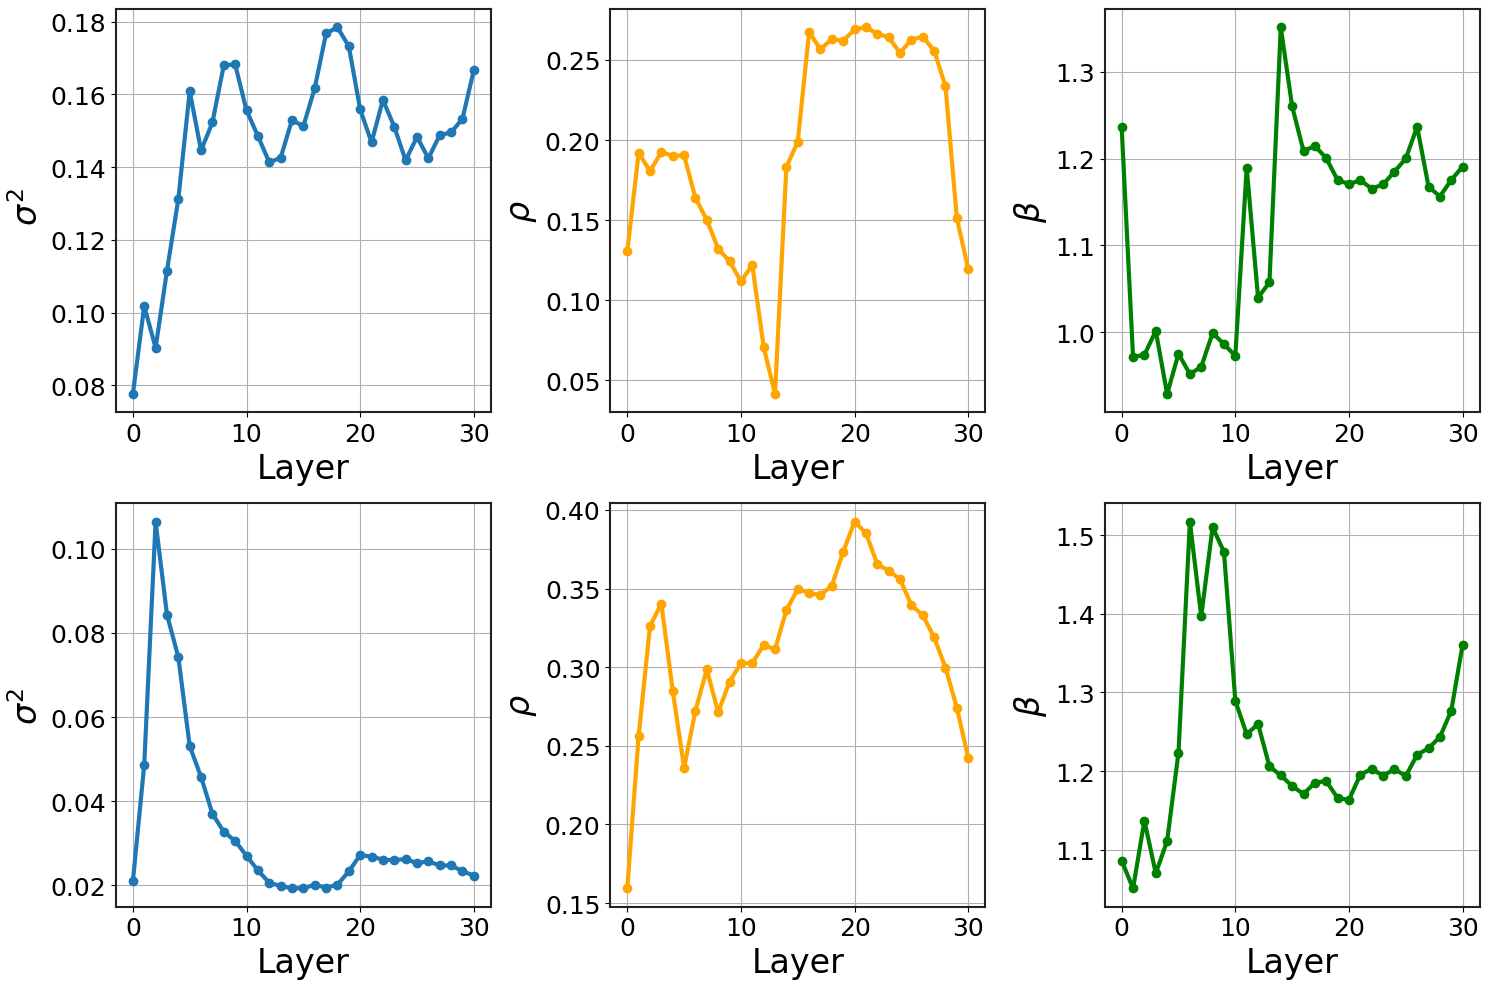

<Figure size 640x480 with 0 Axes>

In [9]:
# PCA results
EVs = [a[i]['Explained_variance'] for i in range(1,len(a))]
rhos = [abs(a[i]['monotonicity_metric']) for i in range(1,len(a))]
betas = [a[i]['sublinearity_metric'] for i in range(1,len(a))]
# PLS results
EVs_PLS = [b[i]['Explained_variance'] for i in range(1,len(b))]
rhos_PLS = [abs(b[i]['monotonicity_metric']) for i in range(1,len(b))]
betas_PLS = [b[i]['sublinearity_metric'] for i in range(1,len(b))]

import matplotlib.pyplot as plt
import os
plt.figure(figsize=(15, 10))
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 24,
    "figure.titlesize": 20,
    "axes.linewidth": 1.5,
    "lines.linewidth": 3,
    "savefig.dpi": 300,
    "axes.grid": False,
    "axes.edgecolor": "#222222",
})

# Row 1: PCA
plt.subplot(2, 3, 1)
plt.plot(EVs, marker='o')
# plt.title('Explained Variance (PCA)')
plt.xlabel('Layer')
plt.ylabel(r' $\sigma^2$')
plt.grid()

plt.subplot(2, 3, 2)
plt.plot(rhos, marker='o', color='orange')
# plt.title('Monotonicity Metric (PCA)')
plt.xlabel('Layer')
plt.ylabel(r'$\rho$')
plt.grid()

plt.subplot(2, 3, 3)
plt.plot(betas, marker='o', color='green')
# plt.title('Sublinearity Metric (PCA)')
plt.xlabel('Layer')
plt.ylabel(r'$\beta$')
plt.grid()

# Row 2: PLS
plt.subplot(2, 3, 4)
plt.plot(EVs_PLS, marker='o')
# plt.title('Explained Variance (PLS)')
plt.xlabel('Layer')
plt.ylabel(r'$\sigma^2$')
plt.grid()

plt.subplot(2, 3, 5)
plt.plot(rhos_PLS, marker='o', color='orange')
# plt.title('Monotonicity Metric (PLS)')
plt.xlabel('Layer')
plt.ylabel(r'$\rho$')
plt.grid()

plt.subplot(2, 3, 6)
plt.plot(betas_PLS, marker='o', color='green')
# plt.title('Sublinearity Metric (PLS)')
plt.xlabel('Layer')
plt.ylabel(r'$\beta$')
plt.grid()
plt.tight_layout()
plt.show()
# Save the current figure as a PDF
plt.savefig("table_2_results_pop_Mistral.pdf", format="pdf")





In [10]:
# Compute averages and prepare report text to write to table_2 file (with append mode)
import os

report_lines = []
report_lines.append(f"{model_name} Accuracy {acc_model}\n")
report_lines.append("\nPCA Analysis:\n")

EVs = [a[i]['Explained_variance'] for i in range(1, len(a))]
rhos = [abs(a[i]['monotonicity_metric']) for i in range(1, len(a))]
betas = [a[i]['sublinearity_metric'] for i in range(1, len(a))]

EVs_avg = sum(EVs) / len(EVs) if EVs else float('nan')
rhos_avg = sum(rhos) / len(rhos) if rhos else float('nan')
betas_avg = sum(betas) / len(betas) if betas else float('nan')

report_lines.append(f"Average Explained Variance: {EVs_avg:.3f}\n")
report_lines.append(f"Average Monotonicity Metric: {rhos_avg:.3f}\n")
report_lines.append(f"Average Sublinearity Metric: {betas_avg:.3f}\n")

# Report highest and second highest EVs and layer numbers, also report monotonicity and sublinearity for these layers
if len(EVs) >= 2:
    # Map EVs to their corresponding layer number (layer = index+1 for i in range(1, len(a)))
    layer_indices = list(range(1, len(a)))
    sorted_evs_with_layers = sorted(
        zip(EVs, rhos, betas, layer_indices), 
        key=lambda x: x[0], 
        reverse=True
    )
    (max_ev, max_rho, max_beta, max_layer) = sorted_evs_with_layers[0]
    (second_ev, second_rho, second_beta, second_layer) = sorted_evs_with_layers[1]
    report_lines.append(f"Highest Explained Variance: {max_ev:.3f} (Layer {max_layer})\n")
    report_lines.append(f"    Monotonicity at this layer: {max_rho:.3f}\n")
    report_lines.append(f"    Sublinearity at this layer: {max_beta:.3f}\n")
    report_lines.append(f"Second Highest Explained Variance: {second_ev:.3f} (Layer {second_layer})\n")
    report_lines.append(f"    Monotonicity at this layer: {second_rho:.3f}\n")
    report_lines.append(f"    Sublinearity at this layer: {second_beta:.3f}\n")
elif len(EVs) == 1:
    report_lines.append(f"Highest Explained Variance: {EVs[0]:.3f} (Layer 1)\n")
    report_lines.append(f"    Monotonicity at this layer: {rhos[0]:.3f}\n")
    report_lines.append(f"    Sublinearity at this layer: {betas[0]:.3f}\n")
    report_lines.append("Second Highest Explained Variance: N/A\n")
else:
    report_lines.append("No Explained Variance values available.\n")

# Repeat for PLS results (variable 'b')
EVs_PLS = [b[i]['Explained_variance'] for i in range(1, len(b))]
rhos_PLS = [abs(b[i]['monotonicity_metric']) for i in range(1, len(b))]
betas_PLS = [b[i]['sublinearity_metric'] for i in range(1, len(b))]

EVs_avg_PLS = sum(EVs_PLS) / len(EVs_PLS) if EVs_PLS else float('nan')
rhos_avg_PLS = sum(rhos_PLS) / len(rhos_PLS) if rhos_PLS else float('nan')
betas_avg_PLS = sum(betas_PLS) / len(betas_PLS) if betas_PLS else float('nan')

report_lines.append("\nPLS Analysis:\n")
report_lines.append(f"Average Explained Variance (PLS): {EVs_avg_PLS:.3f}\n")
report_lines.append(f"Average Monotonicity Metric (PLS): {rhos_avg_PLS:.3f}\n")
report_lines.append(f"Average Sublinearity Metric (PLS): {betas_avg_PLS:.3f}\n")

if len(EVs_PLS) >= 2:
    layer_indices_PLS = list(range(1, len(b)))
    sorted_evs_with_layers_PLS = sorted(
        zip(EVs_PLS, rhos_PLS, betas_PLS, layer_indices_PLS), 
        key=lambda x: x[0], 
        reverse=True
    )
    (max_ev_pls, max_rho_pls, max_beta_pls, max_layer_pls) = sorted_evs_with_layers_PLS[0]
    (second_ev_pls, second_rho_pls, second_beta_pls, second_layer_pls) = sorted_evs_with_layers_PLS[1]
    report_lines.append(f"Highest Explained Variance (PLS): {max_ev_pls:.3f} (Layer {max_layer_pls})\n")
    report_lines.append(f"    Monotonicity at this layer: {max_rho_pls:.3f}\n")
    report_lines.append(f"    Sublinearity at this layer: {max_beta_pls:.3f}\n")
    report_lines.append(f"Second Highest Explained Variance (PLS): {second_ev_pls:.3f} (Layer {second_layer_pls})\n")
    report_lines.append(f"    Monotonicity at this layer: {second_rho_pls:.3f}\n")
    report_lines.append(f"    Sublinearity at this layer: {second_beta_pls:.3f}\n")
elif len(EVs_PLS) == 1:
    report_lines.append(f"Highest Explained Variance (PLS): {EVs_PLS[0]:.3f} (Layer 1)\n")
    report_lines.append(f"    Monotonicity at this layer: {rhos_PLS[0]:.3f}\n")
    report_lines.append(f"    Sublinearity at this layer: {betas_PLS[0]:.3f}\n")
    report_lines.append("Second Highest Explained Variance (PLS): N/A\n")
else:
    report_lines.append("No Explained Variance (PLS) values available.\n")

# Write to table_2 in save_path (append mode)
table_2_path = os.path.join(save_path, "table_2")
with open(table_2_path, "a") as f:
    for line in report_lines:
        f.write(line)
    f.write("="*30)
    f.write("\n")
# Optionally, still print to stdout as well
print("".join(report_lines))

meta-llama/Llama-2-7b-hf Accuracy 0.0

PCA Analysis:
Average Explained Variance: 0.147
Average Monotonicity Metric: 0.195
Average Sublinearity Metric: 1.118
Highest Explained Variance: 0.178 (Layer 19)
    Monotonicity at this layer: 0.263
    Sublinearity at this layer: 1.201
Second Highest Explained Variance: 0.177 (Layer 18)
    Monotonicity at this layer: 0.257
    Sublinearity at this layer: 1.215

PLS Analysis:
Average Explained Variance (PLS): 0.033
Average Monotonicity Metric (PLS): 0.314
Average Sublinearity Metric (PLS): 1.231
Highest Explained Variance (PLS): 0.106 (Layer 3)
    Monotonicity at this layer: 0.326
    Sublinearity at this layer: 1.137
Second Highest Explained Variance (PLS): 0.084 (Layer 4)
    Monotonicity at this layer: 0.340
    Sublinearity at this layer: 1.070



In [11]:
results_correct = {i: {'hidden_states': {}, 'answers': {},'pred_answers': {}} for i in range(model_num_layer)}
for layer,V in results.items():
    results_correct[layer]['hidden_states'] = {i:[] for i in range(10)}
    results_correct[layer]['answers'] = {i:[] for i in range(10)}
    results_correct[layer]['pred_answers'] = {i:[] for i in range(10)}
    for g,W in V['hidden_states'].items():
        for i,ele in enumerate(results[layer]['hidden_states'][g]):
            try:
                if int(results[layer]['answers'][g][i]) == int(results[layer]['pred_answers'][g][i]):
                    results_correct[layer]['hidden_states'][g].append(ele)
                    results_correct[layer]['answers'][g].append(results[layer]['answers'][g][i])
                    results_correct[layer]['pred_answers'][g].append(results[layer]['pred_answers'][g][i])
            except:
                pass



In [ ]:
c = 1
for (group, prompt_list), (group_ans, ans_list) in zip(prompts['prmts'].items(), prompts['ans'].items()):
    group_hidden_states = {i: [] for i in range(model_num_layer)}
    group_answers = []
    for prompt, crr_answer in zip(prompt_list, ans_list):
        output = res.generate(prompt,30)
        print(output,"correct",crr_answer)
        c+=1
    if c==10:break
    